In [4]:
# Comando Preventivo utile a forzare l'utilizzo di specifici certificati da parte di Speasy presente nell'Ambiente Virtuale
import os, certifi

os.environ["SSL_CERT_FILE"] = certifi.where()
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

In [5]:
# Inizializzazione Librerie
import speasy as spz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
from matplotlib import colors
import spiceypy as spice
from datetime import datetime, timezone

In [6]:
# (1) Funzione utile all'esplorazione della libreria di Speasy
def visualizer(folder):
    for voice in dir(folder):
        if not voice.startswith("_"):
            print(voice)
    return voice
# (2) Funzione utile all'esplorazione degli strumenti contenuti sulla sonda Voyager 2
def organizer1():
    catalogue= dir(voy2)
    payload=[]
    for instrument in catalogue:
        if (not instrument.startswith("__")) and any(char.isupper() for char in instrument):
            payload.append(instrument)
        else:
            exit
    return payload
# (3) Funzione utile a semplificare l'accesso ai dati provenienti da speasy:
def veryspeasy(folder,startdata,endata):
    start=str(startdata[2])+"-"+str(startdata[1])+"-"+str(startdata[0])
    end=str(endata[2])+"-"+str(endata[1])+"-"+str(endata[0])
    data_of_folder=spz.get_data(folder,start,end)
    df_list=[]
    for v in data_of_folder.variables:
        v_data=data_of_folder.variables[v]
        df=v_data.to_dataframe()
        df_list.append(df)
    DF=pd.concat(df_list,axis=1)
    return DF

In [7]:
# Rimuovo gli archivi di cui non mi interessano i dati al fine di velocizzare l'estrazione:
spz.config.core.disabled_providers.set('sscweb,cdaweb,csa') 
# Accesso al datatree:
amda_tree = spz.inventories.tree.amda
# Sfrutto la funzione "dir" per comprendere gli elementi presenti all'interno del datatree. Per maggiore comodità filtro gli attributi 
# reali all'interno del dataset tralasciando i "metodi speciali". Questa operazione verrà ripetuta numerose volte, dunque creo una funzione 
# che possa svolgere il lavoro velocemente (1).
print("Voci presenti all'interno del datatree di AMDA:")
visualizer(amda_tree)
print("\n")

Voci presenti all'interno del datatree di AMDA:
Catalogs
Parameters
TimeTables
build_date
clear
spz_name
spz_provider
spz_type
spz_uid




In [8]:
# Tramite autocompletamento navigo nelle sezioni fino a giungere alla missione Voyager 2 di cui ho interesse.
print("Catalogo delle missioni di cui sono presenti informazioni:")
visualizer(amda_tree.Parameters)
print("\n")

Catalogo delle missioni di cui sono presenti informazioni:
ACE
AMPTE
ARTEMIS
Astronomical_Objects_Ephemerides
BepiColombo
Cassini
Cluster
DSCOVR
Double_Star
EISCAT
Freja
Galileo
Geotail
Giotto
HelioSwarm
Helios
ICE
IMP
ISEE
Indices
Interball
JASON3
JUICE
Juno
MAVEN
MESSENGER
MEX
MGS
MMS
Magnetic_Field_Models
Mariner_10
OMNI
PSP
PVO
Phobos_2
Pioneer
Planets_Properties
Polar
Rosetta
SOHO
STEREO
SolarOrbiter
Solar_Irradiance
Solar_Wind_Propagation_Models
Swarm
THEMIS
Ulysses
VEX
Voyager
Wind
clear
desc
is_public
name
spz_name
spz_provider
spz_type
spz_uid
xmlid




In [9]:
# Individuata la "sottocartella" di interesse riguardante la missione Voyager 2 salvo il contenuto in una nuova variabile
voy2=amda_tree.Parameters.Voyager.Voyager_2
# A questo punto, individuato il ramo di interesse, vado ad estrarre una lista contenente la strumentazione di bordo, 
# con apposito filtro (2):
payload=organizer1()
print(payload)

['CRS', 'Ephemeris', 'LECP', 'MAG', 'PLS', 'PWS', 'spaseId']


In [10]:
# Nella variabile payload adesso saranno presenti tutti gli strumenti contenuti sulla sonda Voyager 2, a cui si potrà attingere
# sfruttando la libreria speasy. Per le finalità del progetto si concentri adesso l'attenzione sul PLS e nello specifico 
# sui dati relativi al flyby attorno Urano:
pls=voy2.PLS.flyby_uranus
print("Informazioni contenute nel PLS inerenti il flyby di Urano:")
visualizer(pls)
print("\n")

Informazioni contenute nel PLS inerenti il flyby di Urano:
clear
is_public
name
spz_name
spz_provider
spz_type
spz_uid
vo2_pls_uraelebr
vo2_pls_uraelefit
vo2_pls_uraionbr
vo2_pls_uraionfit
xmlid




In [11]:
# Arrivati a questo punto all'interno della voce PLS sono presenti diversi set dati: 
# - i primi due con la dicitura vo2_pls_uraele si riferiscono a misurazioni riguardanti gli elettroni; 
# - gli ultimi due con la dicitura vo2_pls_uraion si riferiscono a misurazioni riguardanti gli ioni.
# Le voci "br" e "fit", invece, stanno rispettivamente per "browse" e "fit". Dati della tipologia "browse" sono utili per visualizzazioni 
# veloci del dataset, individuazione di animalie, filtraggio intervallo di tempi interessanti; mentre dati della tipologia "fit" sono da 
# preferire per analisi quantitative accurate o per la pubblicazione di risultati affidabili. L'obiettivo di questo lavoro verte sulla 
# rappresentazione di immagini scientifiche attendabili, per cui si farà riferimento solo a quest'ultima tipologia.
e_moments=pls.vo2_pls_uraelefit
i_moments=pls.vo2_pls_uraionfit
# Raggiunte finalmente le variabili di interesse è necessario adesso estrarne i valori per poterli manipolare. Il normale accesso ai dati 
# tramite speasy per quanto comodo nell'ambiente di lavoro è stato per me molto macchinoso e complicato. Motivo per cui ho creato una 
# funzione che rendesse l'estrazione dei dati molto più comoda e veloce (3):
DF_electro=veryspeasy(e_moments,[24,1,1986],[25,1,1986])
DF_ion=veryspeasy(i_moments,[24,1,1986],[25,1,1986])

In [12]:
# Ottenute le informazioni relative alle diverse grandezze misurate dal PLS, al fine di ottenere delle rappresentazioni capaci di mettere in
# relazione tali dati con le coordinate spaziali della sonda nei precisi istanti di tempo, viene impiegata la libreria SpeasyPy capace di 
# generare in modo analitico la posizione degli oggetti richiesti. Di seguito, dunque, verranno implementati i dataframe appena estratti al fine
# di ottenere delle nuove colonne contenenti la posizione della sonda in termini di "x","y","z" e successivamente trasformati in "r","long","lat"
# secondo riferimento sferico:
def get_position(dataframe):
    # Imposto le condizioni per garantire l'operatività di SpiceyPy e creo 6 liste vuote: le prime 3 andranno a contenere 
    # le diverse posizioni generate in termini di coordinate cartesiane
    spice.furnsh("vo2MetaK.txt")
    x_lista_coordinate=[]
    y_lista_coordinate=[]
    z_lista_coordinate=[]
    # e le successive 3 conterranno sempre posizioni, ma in termini di coordinate sferiche
    r_lista=[]
    lon_lista=[]
    lat_lista=[]

    # Creo la variabile timespan che corrisponde alla lista di istanti temporali in cui si vuole sapere le coordinate della sonda
    timespan=list(dataframe.index)
    for t in timespan:
        tc=t.to_pydatetime() #converto timestamp di pandas in datatime di python
        et=spice.datetime2et(tc)
        # Genero in primo luogo il set di coordinate cartesiane
        pos, _ = spice.spkpos("VOYAGER 2", et, "IAU_URANUS", "NONE", "URANUS BARYCENTER")
        pos_ru=pos/25559.0 # Divido i risultati per il raggio uraniano in modo da ottenere una normalizzazione delle misure
        x_lista_coordinate.append(pos_ru[0])
        y_lista_coordinate.append(pos_ru[1])
        z_lista_coordinate.append(pos_ru[2])
        # Successivamente sfrutto la funzione presente all'interno di spiceypy per passare al set sferico:
        r, lon, lat = spice.reclat(pos_ru)
        r_lista.append(r)
        lon_lista.append(np.degrees(lon))  # facendo attenzione a passare da radianti a gradi
        lat_lista.append(np.degrees(lat))  # facendo attenzione a passare da radianti a gradi
    # Si organizzano i dati all'interno di un dataframe:
    data={"delta t":timespan,"x":x_lista_coordinate,"y":y_lista_coordinate,"z":z_lista_coordinate,"r":r_lista,"long":lon_lista,"lat":lat_lista}
    df=pd.DataFrame(data)
    # Imposto l'indicizzazione del dataframe in modo analogo a quello di partenza
    df["delta t"] = pd.to_datetime(df["delta t"])
    df = df.set_index("delta t")
    # Creato il DataFrame con le posizioni Generate lo si unisce finalmente a quello estratto inizialmente da AMDA:
    df = df.rename(columns={
    "x": "pos_x",
    "y": "pos_y",
    "z": "pos_z"})
    dataframe = dataframe.join(df)
    spice.kclear()
    return dataframe

# Si utilizza la funzione sui due dataframe di interesse:
DF_electro = get_position(DF_electro)
DF_ion = get_position(DF_ion)

In [13]:
# Prima di procedere con la rappresentazione grafica dei risultati ottenuti, sfrutto ulteriormente la libreria SpiceyPy per ottenere una stima 
# delle traiettorie dei principali satelliti naturali posseduti da Urano. Tale informazione verrà successivamente implementata negli schemi al 
# fine di cogliere o studiare eventuali nessi fra la disposizione delle particelle cariche rilevate e le lune del pianeta.
def get_moon_position(sat):
    # Imposto le condizioni per garantire l'operatività di SpiceyPy e creo 6 liste vuote: le prime 3 andranno a contenere 
    # le diverse posizioni generate in termini di coordinate cartesiane
    spice.furnsh("vo2MetaK.txt")
    x_lista_coordinate=[]
    y_lista_coordinate=[]
    z_lista_coordinate=[]
    # e le successive 3 conterranno sempre posizioni, ma in termini di coordinate sferiche
    r_lista=[]
    lon_lista=[]
    lat_lista=[]

    # Creo la variabile timespan che corrisponde alla lista di istanti temporali in cui si vuole sapere le coordinate della sonda
    timespan=list(DF_electro.index)
    for t in timespan:
        tc=t.to_pydatetime() #converto timestamp di pandas in datatime di python
        et=spice.datetime2et(tc)
        # Genero in primo luogo il set di coordinate cartesiane
        pos, _ = spice.spkpos(sat, et, "IAU_URANUS", "NONE", "URANUS BARYCENTER")
        pos_ru=pos/25559.0 # Divido i risultati per il raggio uraniano in modo da ottenere una normalizzazione delle misure
        x_lista_coordinate.append(pos_ru[0])
        y_lista_coordinate.append(pos_ru[1])
        z_lista_coordinate.append(pos_ru[2])
        # Successivamente sfrutto la funzione presente all'interno di spiceypy per passare al set sferico:
        r, lon, lat = spice.reclat(pos_ru)
        r_lista.append(r)
        lon_lista.append(np.degrees(lon))  # facendo attenzione a passare da radianti a gradi
        lat_lista.append(np.degrees(lat))  # facendo attenzione a passare da radianti a gradi
    # Si organizzano i dati all'interno di un dataframe:
    data={"delta t":timespan,"x":x_lista_coordinate,"y":y_lista_coordinate,"z":z_lista_coordinate,"r":r_lista,"long":lon_lista,"lat":lat_lista}
    df=pd.DataFrame(data)
    # Imposto l'indicizzazione del dataframe in modo analogo a quello di partenza
    df["delta t"] = pd.to_datetime(df["delta t"])
    df = df.set_index("delta t")
    # Creato il DataFrame con le posizioni Generate lo si unisce finalmente a quello estratto inizialmente da AMDA:
    df = df.rename(columns={
    "x": "pos_x",
    "y": "pos_y",
    "z": "pos_z"})
    spice.kclear()
    return df

# Sfrutto adesso la funzione appena creata:
miranda = get_moon_position("MIRANDA")
ariel   = get_moon_position("ARIEL")
umbriel = get_moon_position("UMBRIEL")
titania = get_moon_position("TITANIA")
oberon  = get_moon_position("OBERON")

In [14]:
# Una volta importate le informazioni di traiettoria delle varie lune di Urano creo una funzione che in modo semplificato possa
# rappresentare le orbite dei vari satelliti in modo automatico, in modo tale da poterla utilizzare direttamente per aggiungere tale dato 
# alle visualizzazioni create. Sulla base dei dati ottenuti e delle conoscenze scientifiche posso dedurre che all'interno dei 
# Meridian Chart le lune saranno assimilabili a punti, mentre all'interno dei Phase Chart la traiettoria dei satelliti potrà essere approssimata
# a cerchi concentrici
def show_moon_lat(subplot,info):
    # Dizionario con dataframe delle lune di Urano
    satellites = {"Miranda": miranda, "Ariel":ariel, "Umbriel": umbriel, 
                          "Titania": titania, "Oberon": oberon}
    # Dizionario con colori delle Lune (puro fattore estetico):
    moon_colors = {"Miranda": "lightgray",   # superficie fratturata, chiaro
                    "Ariel": "silver",        # più luminoso
                    "Umbriel": "dimgray",     # il più scuro
                    "Titania": "darkslategray",
                    "Oberon": "slategray"}
    if info==0: # Le Informazioni relative alle Lune vengono mostrate su apposita Leggenda
        for name, df in satellites.items():
            # Coordinate medie
            r_mean = df["r"].mean()
            lat_mean = np.radians(df["lat"].mean()+90)
            # Disegno la posizione della luna
            subplot.scatter(lat_mean, r_mean, color=moon_colors[name], edgecolor='black', s=40, label=name, zorder=3)
    elif info==1: # Le Informazioni relative alle Lune vengono mostrate direttamente sulla Rappresentazione
        for i, (name, df) in enumerate(satellites.items()):
            # Coordinate medie
            r_mean = df["r"].mean()
            lat_mean = np.radians(df["lat"].mean()+90)
            # Disegno la posizione della luna
            subplot.scatter(lat_mean, r_mean, color=moon_colors[name], edgecolor='black', s=40, zorder=3)
            # Alterno sopra/sotto a seconda dell’indice
            if i % 2 == 0:  
                # Etichetta sopra
                subplot.text(lat_mean+np.radians(5), r_mean + 0.5, name,
                            color=moon_colors[name],
                            fontsize=9, fontweight="bold",
                            ha="center", va="bottom")
            else:
                # Etichetta sotto
                subplot.text(lat_mean-np.radians(5), r_mean - 0.5, name,
                            color=moon_colors[name],
                            fontsize=9, fontweight="bold",
                            ha="center", va="top")

def show_moon_long(subplot,info):
    # Dizionario con dataframe delle lune di Urano
    satellites = {"Miranda": miranda, "Ariel":ariel, "Umbriel": umbriel, 
                          "Titania": titania, "Oberon": oberon}
    # Dizionario con colori delle Lune (puro fattore estetico):
    moon_colors = {"Miranda": "lightgray",   # superficie fratturata, chiaro
                    "Ariel": "silver",        # più luminoso
                    "Umbriel": "dimgray",     # il più scuro
                    "Titania": "darkslategray",
                    "Oberon": "slategray"}
    if info==0: # Le Informazioni relative alle Lune vengono mostrate su apposita Leggenda
        for name,df in satellites.items():
            r=df["r"]
            lon_moon_plot=np.radians(df["long"])
            # Disegno la traiettoria:
            subplot.plot(lon_moon_plot,r,color=moon_colors[name],linestyle=":",linewidth=1.5,label=name)
    elif info==1: # Le Informazioni relative alle Lune vengono mostrate direttamente sulla Rappresentazione
        for name,df in satellites.items():
            r=df["r"]
            lon_moon_plot=np.radians(df["long"])
            # Disegno la traiettoria:
            subplot.plot(lon_moon_plot,r,color=moon_colors[name],linestyle=":",linewidth=1.5)
            # Posiziono il nome della luna in corrispondenza della media della sua orbita
            lon_mean = np.radians(df["long"].mean())   # angolo medio
            r_mean = r.mean()                          # raggio medio
            subplot.text(lon_mean, r_mean, name,
                        color=moon_colors[name],
                        fontsize=7, fontweight="bold",
                        ha="center", va="bottom")

def show_moon_cart(subplot):
    # Dizionario con dataframe delle lune di Urano
    satellites = {"Miranda": miranda, "Ariel":ariel, "Umbriel": umbriel, 
                          "Titania": titania, "Oberon": oberon}
    # Dizionario con colori delle Lune (puro fattore estetico):
    moon_colors = {"Miranda": "lightgray",   # superficie fratturata, chiaro
                    "Ariel": "silver",        # più luminoso
                    "Umbriel": "dimgray",     # il più scuro
                    "Titania": "darkslategray",
                    "Oberon": "slategray"}
    # Limiti dell’asse y per posizionare le etichette
    y_max = subplot.get_ylim()[1]
    for name,df in satellites.items():
        subplot.axvline(df['r'].mean(),color=moon_colors[name],linestyle="--",linewidth=1)
        subplot.text(df['r'].mean()+0.35, y_max * 0.98,   # posizione leggermente sotto il bordo superiore
            name,
            color=moon_colors[name],
            fontsize=8,
            ha='center', va='top',
            rotation=270)

In [15]:
# Per motivi di rappresentazione che saranno meglio comprensibili in seguito creo un ulteriore funzione che per una data posizione della sonda
# Voyager 2 restituisca il punto corrispondente la posizione delle Lune:
def moon_encounter():
    '''Restituisce i tempi/posizioni delle lune principali di Urano collegandoli alla rispettiva posizione 
        di Voyager 2 nello stesso istante temporale'''
    # Dizionario con dataframe delle lune di Urano
    satellites = {"Miranda": miranda, "Ariel":ariel, "Umbriel": umbriel, 
                          "Titania": titania, "Oberon": oberon}

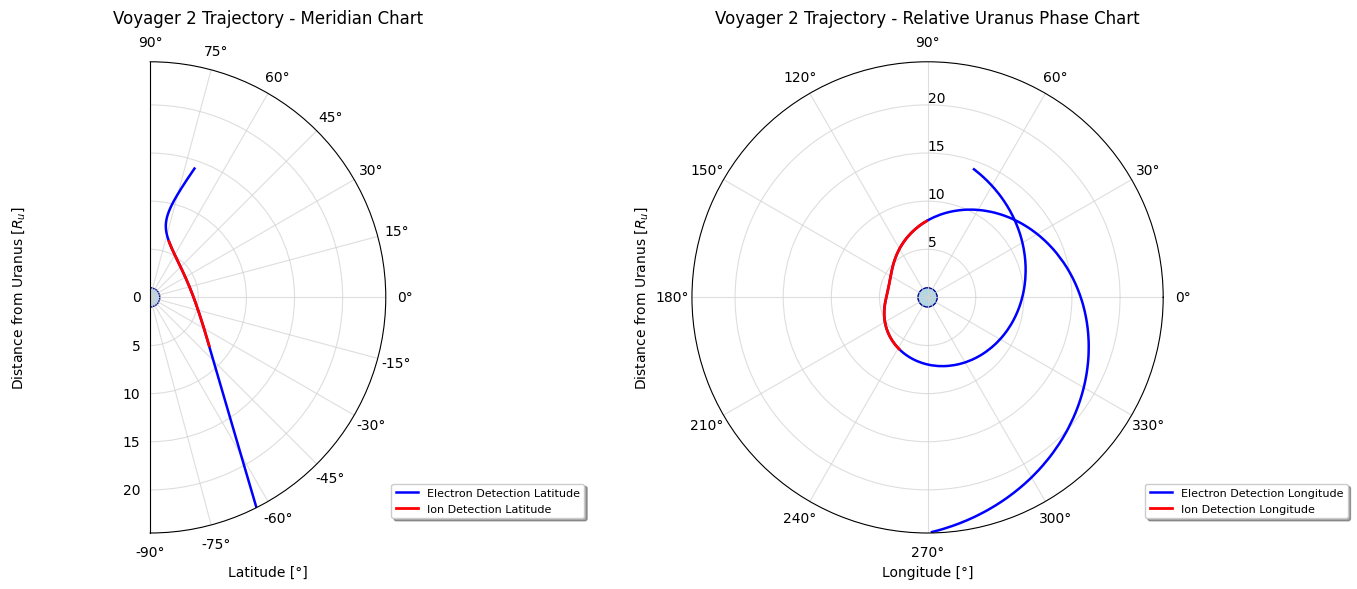

In [16]:
# Conclusa la parte di elaborazione dati utile alla sintesi delle coordinate sferiche della sonda nei timespan di funzionamento del PLS, da
# questo punto in poi si creano tutte le immagini utili ad ottenere una migliore interpretazione dei dati raccolti:

# GRAFICO 1: Rappresentazione delle Traiettoria del Satellite e delle Porzioni di Funzionamento del PLS
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Grafico 1a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_electro['r'])+0.1)

# Rappresentazione Latitudine Rilevazione Electro
lat_electro_plot = np.radians((DF_electro['lat'])+90)
ax1.plot(lat_electro_plot, DF_electro['r'], color="blue", linewidth=1.8, label="Electron Detection Latitude")

# Rappresentazione Latitudine Rilevazione Electro
lat_ion_plot = np.radians((DF_ion['lat'])+90)
ax1.plot(lat_ion_plot, DF_ion['r'], color="red", linewidth=2, label="Ion Detection Latitude")

# Rappresentazione delle Lune
#show_moon_lat(ax1,1)

# Cerchio con raggio 1 Ru (quindi Urano)
uranus_circle = mpatches.Circle((0,0), 1, transform=ax1.transData._b, 
                                facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax1.add_patch(uranus_circle)

ax1.grid(color='lightgray',alpha=0.75)
ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Voyager 2 Trajectory - Meridian Chart', va='bottom')
ax1.set_xlabel('Latitude [°]')
ax1.set_ylabel('Distance from Uranus [$R_u$]')
ax1.legend(loc='lower left', bbox_to_anchor=(0.75, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Grafico 1b: Phase Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(0,
             max(DF_electro['r'])+0.1)
ax2.set_rlabel_position(90)

# Rappresentazione Longitudine Rilevazione Electro
lon_electro_plot = np.radians(DF_electro['long'])
ax2.plot(lon_electro_plot, DF_electro['r'], color="blue", linewidth=1.8, label="Electron Detection Longitude")

# Rappresentazione Longitudine Rilevazione Ioni
lon_ion_plot = np.radians((DF_ion['long']))
ax2.plot(lon_ion_plot, DF_ion['r'], color="red", linewidth=2, label="Ion Detection Longitude")

# Rappresentazione delle Lune
#show_moon_long(ax2,1)

# Cerchio con raggio 1 Ru (quindi Urano)
uranus_circle2 = mpatches.Circle((0,0), 1, transform=ax2.transData._b, 
                                 facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax2.add_patch(uranus_circle2)

ax2.grid(color='lightgray',alpha=0.75)
ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Voyager 2 Trajectory - Relative Uranus Phase Chart', va='bottom')
ax2.set_xlabel('Longitude [°]')
ax2.set_ylabel('Distance from Uranus [$R_u$]', labelpad=30)
ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Mostro il risultato combinato
plt.tight_layout()
plt.show()

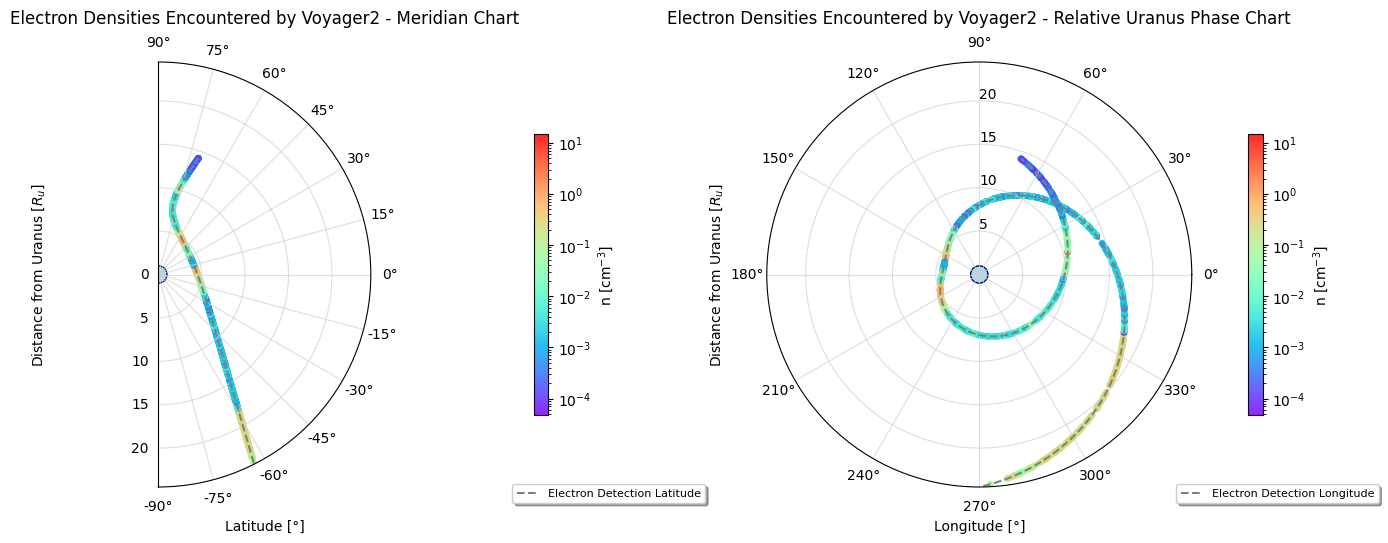

In [17]:
# GRAFICO 2: Rappresentazione delle Densità Totali di Elettroni Rilevate:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Grafico 2a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_electro['r'])+0.1)

lat_electro_plot = np.radians((DF_electro['lat'])+90)
ax1.plot(lat_electro_plot, DF_electro['r'], color="grey", linewidth=1.5, linestyle='--', label="Electron Detection Latitude")
sc1=ax1.scatter(lat_electro_plot,DF_electro['r'],c=DF_electro['density total'],cmap='rainbow', norm=LogNorm(),s=15,alpha=0.85)

# Aggiungo la Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile
# Adotto una formattazione logaritmica
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

# Rappresentazione delle Lune:
#show_moon_lat(ax1,0)

# Cerchio con raggio 1 Ru (quindi Urano)
uranus_circle = mpatches.Circle((0,0), 1, transform=ax1.transData._b, 
                                facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax1.add_patch(uranus_circle)

ax1.grid(color='lightgray',alpha=0.75)
ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Electron Densities Encountered by Voyager2 - Meridian Chart', va='bottom')
ax1.set_xlabel('Latitude [°]')
ax1.set_ylabel('Distance from Uranus [$R_u$]')
ax1.legend(bbox_to_anchor=(1.55, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Grafico 2b: Phase Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(0,
             max(DF_electro['r'])+0.1)
ax2.set_rlabel_position(90)

lon_electro_plot = np.radians((DF_electro['long']))
ax2.plot(lon_electro_plot, DF_electro['r'], color="grey", linewidth=1.5, linestyle='--', label="Electron Detection Longitude")
sc2=ax2.scatter(lon_electro_plot, DF_electro['r'], c=DF_electro['density total'],cmap='rainbow',norm=LogNorm(),s=15,alpha=0.85)

# Qui si aggiunge la Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile
# Adotto una formattazione logaritmica
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

# Rappresentazione delle Lune
#show_moon_long(ax2,1)

# Cerchio con raggio 1 Ru (quindi Urano)
uranus_circle2 = mpatches.Circle((0,0), 1, transform=ax2.transData._b, 
                                 facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax2.add_patch(uranus_circle2)

ax2.grid(color='lightgray',alpha=0.75)
ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Electron Densities Encountered by Voyager2 - Relative Uranus Phase Chart', va='bottom')
ax2.set_xlabel('Longitude [°]')
ax2.set_ylabel('Distance from Uranus [$R_u$]', labelpad=30)
ax2.legend(bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Mostro il risultato combinato
plt.tight_layout()
plt.show()

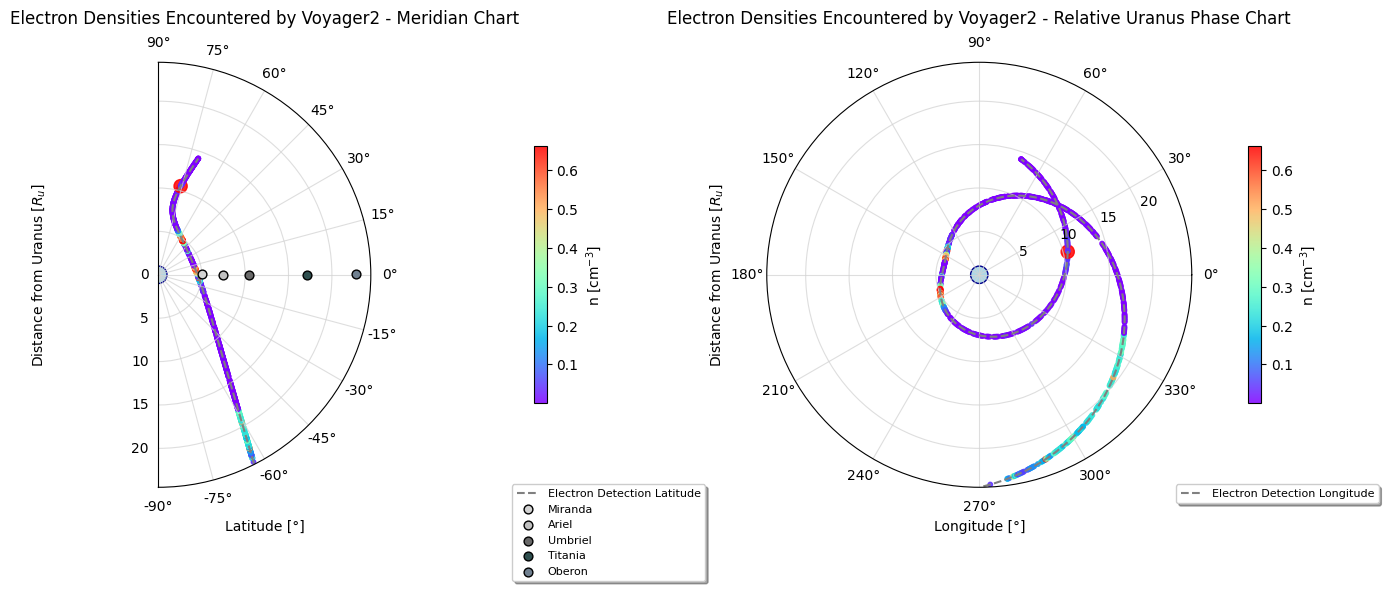

In [18]:
# GRAFICO 2.1: Rappresentazione delle Densità Totali di Elettroni Rilevate [VARIAZIONE NON LOGARITMICA]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Grafico 2.1a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_electro['r'])+0.1)

lat_electro_plot = np.radians((DF_electro['lat'])+90)
ax1.plot(lat_electro_plot, DF_electro['r'], color="grey", linewidth=1.5, linestyle='--', label="Electron Detection Latitude")

# Normalizzazione per colore (outlier estremi che rovinerebbero la rappresentazione vengono appiattiti come significato e adeguati a colori 
# estremi della scala):
norm=colors.Normalize(vmin=DF_electro["density total"].quantile(0.01),vmax=DF_electro["density total"].quantile(0.99))
# Si riscala la dimensione dei marker proporzionalmente alla quantità posseduta:
sizes=(DF_electro['density total']/DF_electro['density total'].max())*80+10
# Traccio nuovamente il grafico:
sc1=ax1.scatter(lat_electro_plot,DF_electro['r'],c=DF_electro['density total'],cmap='rainbow', norm=norm,s=sizes,alpha=0.85)

# Aggiungo la Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile

# Rappresentazione delle Lune:
show_moon_lat(ax1,0)

# Cerchio con raggio 1 Ru (quindi Urano)
uranus_circle = mpatches.Circle((0,0), 1, transform=ax1.transData._b, 
                                facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax1.add_patch(uranus_circle)

ax1.grid(color='lightgray',alpha=0.75)
ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Electron Densities Encountered by Voyager2 - Meridian Chart', va='bottom')
ax1.set_xlabel('Latitude [°]')
ax1.set_ylabel('Distance from Uranus [$R_u$]')
ax1.legend(bbox_to_anchor=(1.55, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Grafico 2.1b: Phase Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(0,
             max(DF_electro['r'])+0.1)

lon_electro_plot = np.radians((DF_electro['long']))
ax2.plot(lon_electro_plot, DF_electro['r'], color="grey", linewidth=1.5, linestyle='--', label="Electron Detection Longitude")

# Normalizzazione per colore (outlier estremi che rovinerebbero la rappresentazione vengono appiattiti come significato e adeguati a colori 
# estremi della scala):
norm=colors.Normalize(vmin=DF_electro["density total"].quantile(0.01),vmax=DF_electro["density total"].quantile(0.99))
# Si riscala la dimensione dei marker proporzionalmente alla quantità posseduta:
sizes=(DF_electro['density total']/DF_electro['density total'].max())*80+10
# Traccio nuovamente il grafico:
sc2=ax2.scatter(lon_electro_plot, DF_electro['r'], c=DF_electro['density total'],cmap='rainbow',norm=norm,s=sizes,alpha=0.85)

# Qui si aggiunge la Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile

# Rappresentazione delle Lune
#show_moon_long(ax2,1)

# Cerchio con raggio 1 Ru (quindi Urano)
uranus_circle2 = mpatches.Circle((0,0), 1, transform=ax2.transData._b, 
                                 facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax2.add_patch(uranus_circle2)

ax2.grid(color='lightgray',alpha=0.75)
ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Electron Densities Encountered by Voyager2 - Relative Uranus Phase Chart', va='bottom')
ax2.set_xlabel('Longitude [°]')
ax2.set_ylabel('Distance from Uranus [$R_u$]', labelpad=30)
ax2.legend(bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Mostro il risultato combinato
plt.tight_layout()
plt.show()

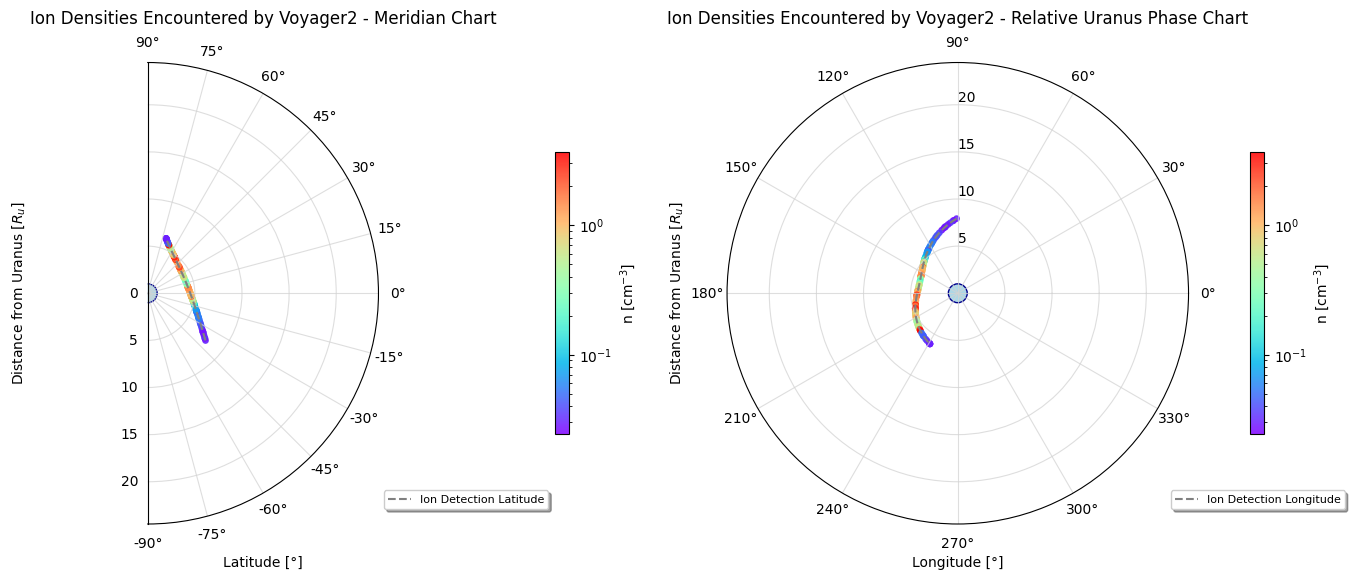

In [19]:
# GRAFICO 3: Rappresentazione delle Densità Totali di Ioni Rilevate [VARIAZIONE NON LOGARITMICA]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Grafico 3a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_electro['r'])+0.1)

lat_ion_plot = np.radians((DF_ion['lat'])+90)
density_total_ion= DF_ion["density comp1"]+ DF_ion["density comp2"]+ DF_ion["density comp3"] # Calcolo la densità totale degli ioni sommando le densità delle singole componenti
ax1.plot(lat_ion_plot, DF_ion['r'], color="grey", linestyle='--', linewidth=1.5, label="Ion Detection Latitude")
sc1=ax1.scatter(lat_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=LogNorm(),s=15,alpha=0.85)

# Aggiungo la Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile
# Adotto una formattazione logaritmica
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

# Rappresentazione delle Lune:
#show_moon_lat(ax1,0)

# Cerchio con raggio 1 Ru (quindi Urano)
uranus_circle = mpatches.Circle((0,0), 1, transform=ax1.transData._b, 
                                facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax1.add_patch(uranus_circle)

ax1.grid(color='lightgray',alpha=0.75)
ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Ion Densities Encountered by Voyager2 - Meridian Chart', va='bottom')
ax1.set_xlabel('Latitude [°]')
ax1.set_ylabel('Distance from Uranus [$R_u$]')
ax1.legend(loc='lower left', bbox_to_anchor=(0.75, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Grafico 3b: Phase Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(0,
             max(DF_electro['r'])+0.1)
ax2.set_rlabel_position(90)

lon_ion_plot = np.radians((DF_ion['long']))
ax2.plot(lon_ion_plot, DF_ion['r'], color="grey", linestyle='--', linewidth=1.5, label="Ion Detection Longitude")
sc2=ax2.scatter(lon_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=LogNorm(),s=15,alpha=0.85)

# Qui si aggiunge la Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile
# Adotto una formattazione logaritmica
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

# Rappresentazione delle Lune:
#show_moon_long(ax2,1)

# Cerchio con raggio 1 Ru (quindi Urano)
uranus_circle2 = mpatches.Circle((0,0), 1, transform=ax2.transData._b, 
                                 facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax2.add_patch(uranus_circle2)

ax2.grid(color='lightgray',alpha=0.75)
ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Ion Densities Encountered by Voyager2 - Relative Uranus Phase Chart', va='bottom')
ax2.set_xlabel('Longitude [°]')
ax2.set_ylabel('Distance from Uranus [$R_u$]', labelpad=30)
ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Mostro il risultato combinato
plt.tight_layout()
plt.show()

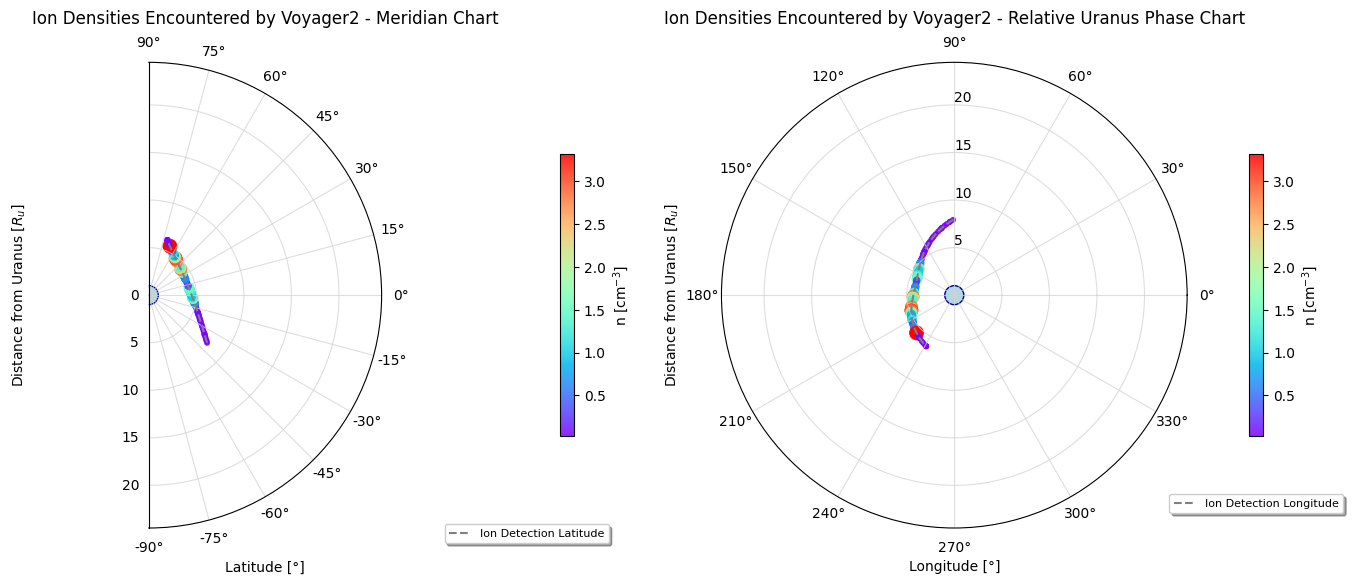

In [20]:
# GRAFICO 3.1: Rappresentazione delle Densità Totali di Ioni Rilevate [VARIAZIONE NON LOGARITMICA]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Grafico 3.1a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_electro['r'])+0.1)

lat_ion_plot = np.radians((DF_ion['lat'])+90)
density_total_ion= DF_ion["density comp1"]+ DF_ion["density comp2"]+ DF_ion["density comp3"] # Calcolo la densità totale degli ioni sommando le densità delle singole componenti
ax1.plot(lat_ion_plot, DF_ion['r'], color="grey", linestyle='--', linewidth=1.5, label="Ion Detection Latitude")

# Normalizzazione per colore (outlier estremi che rovinerebbero la rappresentazione vengono appiattiti come significato e adeguati a colori 
# estremi della scala):
norm=colors.Normalize(vmin=density_total_ion.quantile(0.01),vmax=density_total_ion.quantile(0.99))
# Si riscala la dimensione dei marker proporzionalmente alla quantità posseduta:
sizes=(density_total_ion/density_total_ion.max())*80+10
# Traccio nuovamente il grafico:
sc1=ax1.scatter(lat_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=norm,s=sizes,alpha=0.85)

# Aggiungo la Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile

# Rappresentazione delle Lune:
#show_moon_lat(ax1,0)

# Cerchio con raggio 1 Ru (quindi Urano)
uranus_circle = mpatches.Circle((0,0), 1, transform=ax1.transData._b, 
                                facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax1.add_patch(uranus_circle)

ax1.grid(color='lightgray',alpha=0.75)
ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Ion Densities Encountered by Voyager2 - Meridian Chart', va='bottom')
ax1.set_xlabel('Latitude [°]')
ax1.set_ylabel('Distance from Uranus [$R_u$]')
ax1.legend(bbox_to_anchor=(1.25, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Grafico 3.1b: Phase Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(0,
             max(DF_electro['r'])+0.1)
ax2.set_rlabel_position(90)

lon_ion_plot = np.radians((DF_ion['long']))
ax2.plot(lon_ion_plot, DF_ion['r'], color="grey", linestyle='--', linewidth=1.5, label="Ion Detection Longitude")
# Normalizzazione per colore (outlier estremi che rovinerebbero la rappresentazione vengono appiattiti come significato e adeguati a colori 
# estremi della scala):
norm=colors.Normalize(vmin=density_total_ion.quantile(0.01),vmax=density_total_ion.quantile(0.99))
# Si riscala la dimensione dei marker proporzionalmente alla quantità posseduta:
sizes=(density_total_ion/density_total_ion.max())*80+10
# Traccio nuovamente il grafico:
sc2=ax2.scatter(lon_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=norm,s=sizes,alpha=0.85)

# Qui si aggiunge la Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile

# Rappresentazione delle Lune:
#show_moon_long(ax2,1)

# Cerchio con raggio 1 Ru (quindi Urano)
uranus_circle2 = mpatches.Circle((0,0), 1, transform=ax2.transData._b, 
                                 facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax2.add_patch(uranus_circle2)

ax2.grid(color='lightgray',alpha=0.75)
ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Ion Densities Encountered by Voyager2 - Relative Uranus Phase Chart', va='bottom')
ax2.set_xlabel('Longitude [°]')
ax2.set_ylabel('Distance from Uranus [$R_u$]', labelpad=30)
ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Mostro il risultato combinato
plt.tight_layout()
plt.show()

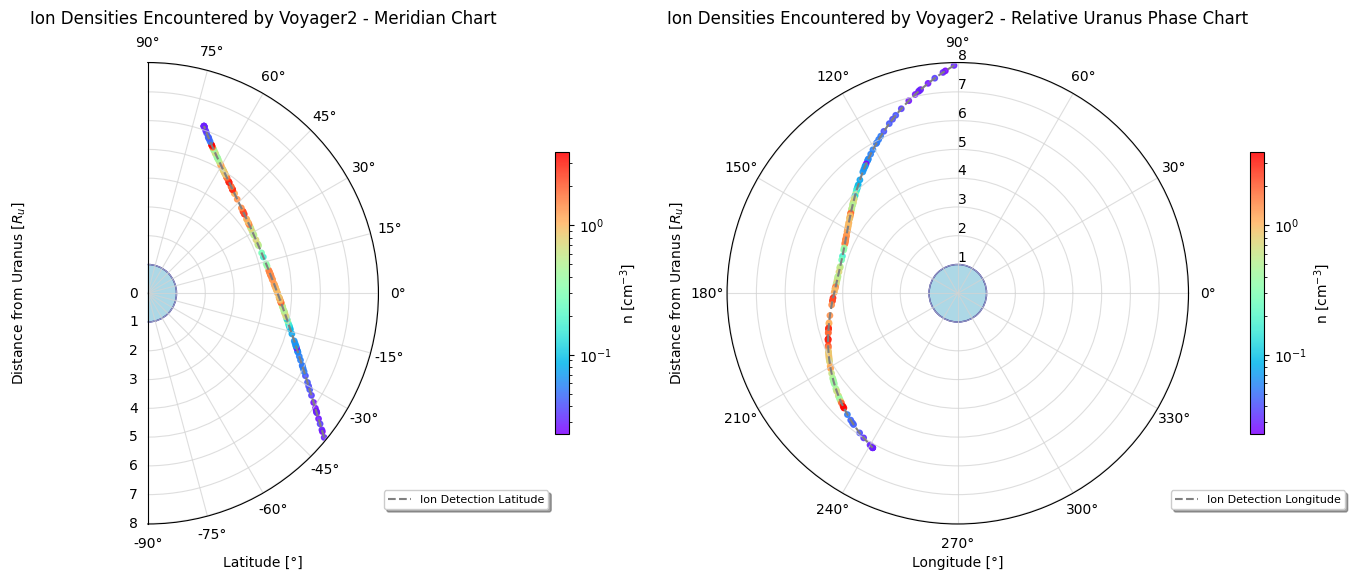

In [21]:
# GRAFICO 3.2: Rappresentazione delle Densità Totali di Ioni Rilevate ZOOM:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Grafico 3.2a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_ion['r'])+0.1)

lat_ion_plot = np.radians((DF_ion['lat'])+90)
density_total_ion= DF_ion["density comp1"]+ DF_ion["density comp2"]+ DF_ion["density comp3"] # Calcolo la densità totale degli ioni sommando le densità delle singole componenti
ax1.plot(lat_ion_plot, DF_ion['r'], color="grey", linestyle='--', linewidth=1.5, label="Ion Detection Latitude")
sc1=ax1.scatter(lat_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=LogNorm(),s=15,alpha=0.85)

# Aggiungo la Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile
# Adotto una formattazione logaritmica
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

# Rappresentazione delle Lune
'''# Dizionario con dataframe delle lune di Urano
satellites = {"Miranda": miranda, "Ariel":ariel}
# Dizionario con colori delle Lune (puro fattore estetico):
moon_colors = {"Miranda": "lightgray",   # superficie fratturata, chiaro
                    "Ariel": "silver"}        # più luminoso
for name, df in satellites.items():
    # Coordinate medie
    r_mean = df["r"].mean()
    lat_mean = np.radians(df["lat"].mean()+90)
    # Disegno la posizione della luna
    ax1.scatter(lat_mean, r_mean, color=moon_colors[name], edgecolor='black', s=40, label=name, zorder=3)'''

# Cerchio con raggio 1 Ru (quindi Urano)
uranus_circle = mpatches.Circle((0,0), 1, transform=ax1.transData._b, 
                                facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax1.add_patch(uranus_circle)

ax1.grid(color='lightgray',alpha=0.75)
ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Ion Densities Encountered by Voyager2 - Meridian Chart', va='bottom')
ax1.set_xlabel('Latitude [°]')
ax1.set_ylabel('Distance from Uranus [$R_u$]')
ax1.legend(loc='lower left', bbox_to_anchor=(0.75, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Grafico 3.1b: Phase Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(0,
             max(DF_ion['r'])+0.1)
ax2.set_rlabel_position(90)

lon_ion_plot = np.radians((DF_ion['long']))
ax2.plot(lon_ion_plot, DF_ion['r'], color="grey", linestyle='--', linewidth=1.5, label="Ion Detection Longitude")
sc2=ax2.scatter(lon_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=LogNorm(),s=15,alpha=0.85)

# Qui si aggiunge la Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile
# Adotto una formattazione logaritmica
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

#Rappresentazione Lune:
'''for name,df in satellites.items():
    r=df["r"]
    lon_moon_plot=np.radians(df["long"])
    # Disegno la traiettoria:
    ax2.plot(lon_moon_plot,r,color=moon_colors[name],linestyle=":",linewidth=1.5)
    # Posiziono il nome della luna in corrispondenza della media della sua orbita
    lon_mean = np.radians(df["long"].mean())   # angolo medio
    r_mean = r.mean()                          # raggio medio
    ax2.text(lon_mean, r_mean, name,
            color=moon_colors[name],
            fontsize=7, fontweight="bold",
            ha="center", va="bottom")'''

# Cerchio con raggio 1 Ru (quindi Urano)
uranus_circle2 = mpatches.Circle((0,0), 1, transform=ax2.transData._b, 
                                 facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax2.add_patch(uranus_circle2)

ax2.grid(color='lightgray',alpha=0.75)
ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Ion Densities Encountered by Voyager2 - Relative Uranus Phase Chart', va='bottom')
ax2.set_xlabel('Longitude [°]')
ax2.set_ylabel('Distance from Uranus [$R_u$]', labelpad=30)
ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Mostro il risultato combinato
plt.tight_layout()
plt.show()

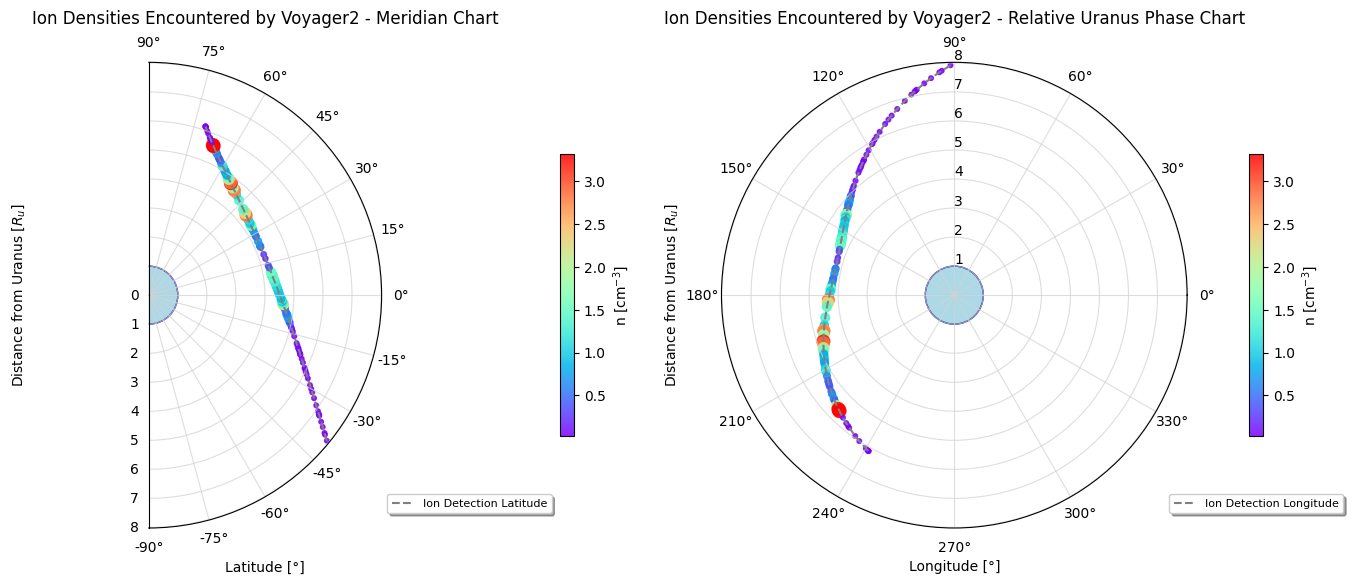

In [22]:
# GRAFICO 3.3: Rappresentazione delle Densità Totali di Ioni Rilevate ZOOM [VARIAZIONE NON LOGARITMICA]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Grafico 3.3a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_ion['r'])+0.1)

lat_ion_plot = np.radians((DF_ion['lat'])+90)
density_total_ion= DF_ion["density comp1"]+ DF_ion["density comp2"]+ DF_ion["density comp3"] # Calcolo la densità totale degli ioni sommando le densità delle singole componenti
ax1.plot(lat_ion_plot, DF_ion['r'], color="grey", linestyle='--', linewidth=1.5, label="Ion Detection Latitude")
# Normalizzazione per colore (outlier estremi che rovinerebbero la rappresentazione vengono appiattiti come significato e adeguati a colori 
# estremi della scala):
norm=colors.Normalize(vmin=density_total_ion.quantile(0.01),vmax=density_total_ion.quantile(0.99))
# Si riscala la dimensione dei marker proporzionalmente alla quantità posseduta:
sizes=(density_total_ion/density_total_ion.max())*80+10
# Traccio nuovamente il grafico:
sc1=ax1.scatter(lat_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=norm,s=sizes,alpha=0.85)

# Aggiungo la Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile

# Rappresentazione Lune:
'''# Dizionario con dataframe delle lune di Urano
satellites = {"Miranda": miranda, "Ariel":ariel}
# Dizionario con colori delle Lune (puro fattore estetico):
moon_colors = {"Miranda": "lightgray",   # superficie fratturata, chiaro
                    "Ariel": "silver"}        # più luminoso
for name, df in satellites.items():
    # Coordinate medie
    r_mean = df["r"].mean()
    lat_mean = np.radians(df["lat"].mean()+90)
    # Disegno la posizione della luna
    ax1.scatter(lat_mean, r_mean, color=moon_colors[name], edgecolor='black', s=40, label=name, zorder=3)
'''
# Cerchio con raggio 1 Ru (quindi Urano)
uranus_circle = mpatches.Circle((0,0), 1, transform=ax1.transData._b, 
                                facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax1.add_patch(uranus_circle)

ax1.grid(color='lightgray',alpha=0.75)
ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Ion Densities Encountered by Voyager2 - Meridian Chart', va='bottom')
ax1.set_xlabel('Latitude [°]')
ax1.set_ylabel('Distance from Uranus [$R_u$]')
ax1.legend(loc='lower left', bbox_to_anchor=(0.75, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Grafico 3.3b: Phase Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(0,
             max(DF_ion['r'])+0.1)
ax2.set_rlabel_position(90)

lon_ion_plot = np.radians((DF_ion['long']))
ax2.plot(lon_ion_plot, DF_ion['r'], color="grey", linestyle='--', linewidth=1.5, label="Ion Detection Longitude")
# Normalizzazione per colore (outlier estremi che rovinerebbero la rappresentazione vengono appiattiti come significato e adeguati a colori 
# estremi della scala):
norm=colors.Normalize(vmin=density_total_ion.quantile(0.01),vmax=density_total_ion.quantile(0.99))
# Si riscala la dimensione dei marker proporzionalmente alla quantità posseduta:
sizes=(density_total_ion/density_total_ion.max())*80+10
# Traccio nuovamente il grafico:
sc2=ax2.scatter(lon_ion_plot, DF_ion['r'], c=density_total_ion,cmap='rainbow',norm=norm,s=sizes,alpha=0.85)

# Qui si aggiunge la Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("n [cm$^{-3}$]")  # etichetta della variabile

# Rappresentazione delle Lune:
'''for name,df in satellites.items():
    r=df["r"]
    lon_moon_plot=np.radians(df["long"])
    # Disegno la traiettoria:
    ax2.plot(lon_moon_plot,r,color=moon_colors[name],linestyle=":",linewidth=1.5)
    # Posiziono il nome della luna in corrispondenza della media della sua orbita
    lon_mean = np.radians(df["long"].mean())   # angolo medio
    r_mean = r.mean()                          # raggio medio
    ax2.text(lon_mean, r_mean, name,
            color=moon_colors[name],
            fontsize=7, fontweight="bold",
            ha="center", va="bottom")'''


# Cerchio con raggio 1 Ru (quindi Urano)
uranus_circle2 = mpatches.Circle((0,0), 1, transform=ax2.transData._b, 
                                 facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax2.add_patch(uranus_circle2)

ax2.grid(color='lightgray',alpha=0.75)
ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Ion Densities Encountered by Voyager2 - Relative Uranus Phase Chart', va='bottom')
ax2.set_xlabel('Longitude [°]')
ax2.set_ylabel('Distance from Uranus [$R_u$]', labelpad=30)
ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Mostro il risultato combinato
plt.tight_layout()
plt.show()

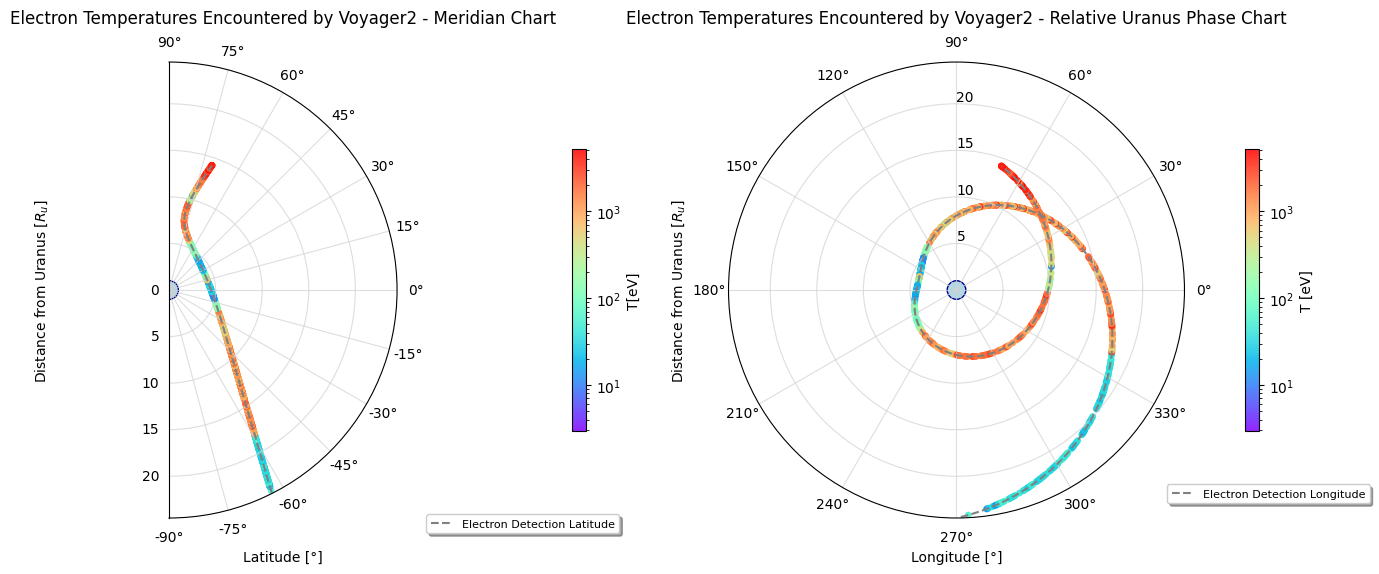

In [23]:
# Grafico 4: Rappresentazione delle Temperature Totali degli Elettroni:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Grafico 4a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_electro['r'])+0.1)

lat_electro_plot = np.radians((DF_electro['lat'])+90)
ax1.plot(lat_electro_plot, DF_electro['r'], color="grey", linewidth=1.5, linestyle='--', label="Electron Detection Latitude")
sc1=ax1.scatter(lat_electro_plot,DF_electro['r'],c=DF_electro['temperature total'],cmap='rainbow', norm=LogNorm(),s=15,alpha=0.85)

# Aggiungo la Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("T[eV]")  # etichetta della variabile
# Adotto una formattazione logaritmica
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

# Rappresentazione delle Lune:
#show_moon_lat(ax1,0)

# Cerchio con raggio 1 Ru (quindi Urano)
uranus_circle = mpatches.Circle((0,0), 1, transform=ax1.transData._b, 
                                facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax1.add_patch(uranus_circle)

ax1.grid(color='lightgray',alpha=0.75)
ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Electron Temperatures Encountered by Voyager2 - Meridian Chart', va='bottom')
ax1.set_xlabel('Latitude [°]')
ax1.set_ylabel('Distance from Uranus [$R_u$]')
ax1.legend(bbox_to_anchor=(1.25, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Grafico 4b: Phase Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(0,
             max(DF_electro['r'])+0.1)
ax2.set_rlabel_position(90)


lon_electro_plot = np.radians((DF_electro['long']))
ax2.plot(lon_electro_plot, DF_electro['r'], color="grey", linewidth=1.5, linestyle='--', label="Electron Detection Longitude")
sc2=ax2.scatter(lon_electro_plot, DF_electro['r'], c=DF_electro['temperature total'],cmap='rainbow',norm=LogNorm(),s=15,alpha=0.85)

# Qui si aggiunge la Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("T [eV]")  # etichetta della variabile
# Adotto una formattazione logaritmica
cbar.formatter = ticker.LogFormatterMathtext(base=10)
cbar.update_ticks()

# Rappresentazione delle Lune:
#show_moon_long(ax2,1)

# Cerchio con raggio 1 Ru (quindi Urano)
uranus_circle2 = mpatches.Circle((0,0), 1, transform=ax2.transData._b, 
                                 facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax2.add_patch(uranus_circle2)

ax2.grid(color='lightgray',alpha=0.75)
ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Electron Temperatures Encountered by Voyager2 - Relative Uranus Phase Chart', va='bottom')
ax2.set_xlabel('Longitude [°]')
ax2.set_ylabel('Distance from Uranus [$R_u$]', labelpad=30)
ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Mostro il risultato combinato
plt.tight_layout()
plt.show()

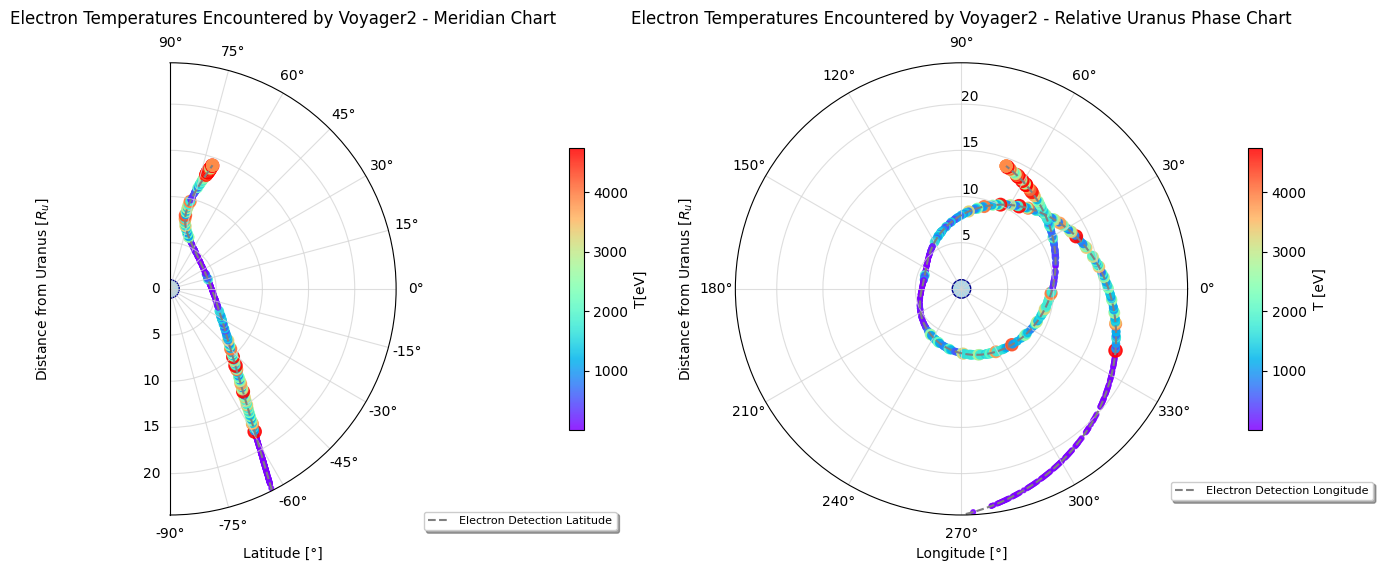

In [24]:
# Grafico 4.1: Rappresentazione delle Temperature Totali degli Elettroni [VARIAZIONE NO LOGARITMICA]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'polar': True}, figsize=(14,6))

# Grafico 4.1a: Meridian Chart
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.set_theta_zero_location('S')
ax1.set_theta_direction(1)

ax1.set_rlim(0,
             max(DF_electro['r'])+0.1)

lat_electro_plot = np.radians((DF_electro['lat'])+90)
ax1.plot(lat_electro_plot, DF_electro['r'], color="grey", linewidth=1.5, linestyle='--', label="Electron Detection Latitude")
# Normalizzazione per colore (outlier estremi che rovinerebbero la rappresentazione vengono appiattiti come significato e adeguati a colori 
# estremi della scala):
norm=colors.Normalize(vmin=DF_electro['temperature total'].quantile(0.01),vmax=DF_electro['temperature total'].quantile(0.99))
# Si riscala la dimensione dei marker proporzionalmente alla quantità posseduta:
sizes=(DF_electro['temperature total']/DF_electro['temperature total'].max())*80+10
# Traccio nuovamente il grafico:
sc1=ax1.scatter(lat_electro_plot,DF_electro['r'],c=DF_electro['temperature total'],cmap='rainbow', norm=norm,s=sizes,alpha=0.85)

# Aggiungo la Colorbar
cbar = plt.colorbar(sc1, ax=ax1, pad=0.1,shrink=0.5)
cbar.set_label("T[eV]")  # etichetta della variabile

# Rappresentazione delle Lune:
#show_moon_lat(ax1,0)

# Cerchio con raggio 1 Ru (quindi Urano)
uranus_circle = mpatches.Circle((0,0), 1, transform=ax1.transData._b, 
                                facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax1.add_patch(uranus_circle)

ax1.grid(color='lightgray',alpha=0.75)
ax1.set_thetagrids([0,15,30,45,60,75,90,105,120,135,150,165,180],
                   labels=['-90°','-75°','-60°','-45°','-30°','-15°','0°','15°','30°','45°','60°','75°','90°'])
ax1.set_title('Electron Temperatures Encountered by Voyager2 - Meridian Chart', va='bottom')
ax1.set_xlabel('Latitude [°]')
ax1.set_ylabel('Distance from Uranus [$R_u$]')
ax1.legend(bbox_to_anchor=(1.25, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Grafico 4.1b: Phase Chart
ax2.set_thetamin(0)
ax2.set_thetamax(360)
ax2.set_theta_zero_location('E')
ax2.set_theta_direction(1)

ax2.set_rlim(0,
             max(DF_electro['r'])+0.1)
ax2.set_rlabel_position(90)

lon_electro_plot = np.radians((DF_electro['long']))
ax2.plot(lon_electro_plot, DF_electro['r'], color="grey", linewidth=1.5, linestyle='--', label="Electron Detection Longitude")
# Normalizzazione per colore (outlier estremi che rovinerebbero la rappresentazione vengono appiattiti come significato e adeguati a colori 
# estremi della scala):
norm=colors.Normalize(vmin=DF_electro['temperature total'].quantile(0.01),vmax=DF_electro['temperature total'].quantile(0.99))
# Si riscala la dimensione dei marker proporzionalmente alla quantità posseduta:
sizes=(DF_electro['temperature total']/DF_electro['temperature total'].max())*80+10
# Traccio nuovamente il grafico:
sc2=ax2.scatter(lon_electro_plot, DF_electro['r'], c=DF_electro['temperature total'],cmap='rainbow',norm=norm,s=sizes,alpha=0.85)

# Qui si aggiunge la Colorbar
cbar = plt.colorbar(sc2, ax=ax2, pad=0.1,shrink=0.5)
cbar.set_label("T [eV]")  # etichetta della variabile

# Rappresentazione delle Lune:
#show_moon_long(ax2,1)

# Cerchio con raggio 1 Ru (quindi Urano)
uranus_circle2 = mpatches.Circle((0,0), 1, transform=ax2.transData._b, 
                                 facecolor="lightblue", edgecolor="darkblue", alpha=1, zorder=0)
ax2.add_patch(uranus_circle2)

ax2.grid(color='lightgray',alpha=0.75)
ax2.set_thetagrids([0,30,60,90,120,150,180,210,240,270,300,330])
ax2.set_title('Electron Temperatures Encountered by Voyager2 - Relative Uranus Phase Chart', va='bottom')
ax2.set_xlabel('Longitude [°]')
ax2.set_ylabel('Distance from Uranus [$R_u$]', labelpad=30)
ax2.legend(loc='lower left', bbox_to_anchor=(0.95, 0.02),
           frameon=True, shadow=True, fancybox=True, fontsize=8)

# Mostro il risultato combinato
plt.tight_layout()
plt.show()

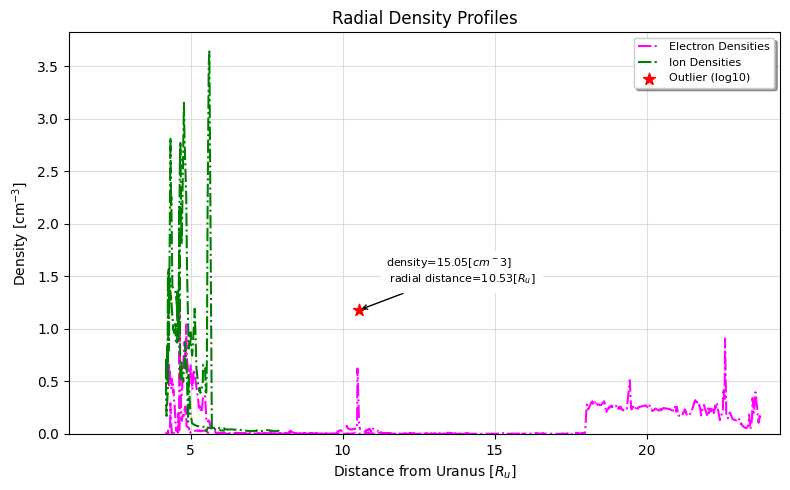

In [25]:
# Grafico 5: Rappresentazione della Densità Totale di Ioni ed Elettroni Rilevati in relazione alla Distanza Radiale Occupata 
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111) #Questo 111 serve a chiarire al programma che si vuole una sola area di disegno (1 riga, 1 colonna, 1° plot)

# Rappresentazione Grafica dei Dati
# Nel caso delle misurazioni inerenti gli elettroni è presente un valore "di disturbo" pari a "15.05", secondo mie supposizioni si tratta di un
# valore errato poiché non ha alcuna coerenza con i dati precedentemente e successivamente raccolti; decido quindi di escluderlo dalla 
# seguente figura per ottenere una migliore visualizzazione mediante utilizzo di una maschera:
# Creo la maschera: True per tutti i valori DIVERSI dal massimo
maschera = DF_electro['density total'] != DF_electro['density total'].max()

# La maschera avrà:
# - True per tutti i valori ≠ valore_max
# - False solo per il valore massimo

# Densità degli Elettroni:
ax.plot(DF_electro['r'][maschera], DF_electro['density total'][maschera], color='magenta', linewidth=1.5, linestyle='-.', label="Electron Densities")
# Densità degli Ioni:
ax.plot(DF_ion['r'], density_total_ion, color='green', linewidth=1.5, linestyle='-.', label="Ion Densities")

# Per completezza di rappresentazione inserisco il valore precedentemente etichettato come "disturbo". Al fine di ottenere una visualizzazione
# gradevole inserisco il dato in forma logaritmica:
max_density_value=DF_electro["density total"].max()
id_max_density=DF_electro["density total"].idxmax()
r_max_density = DF_electro.loc[id_max_density, "r"]
ax.scatter(r_max_density, np.log10(max_density_value), color='red', marker='*', s=80, label="Outlier (log10)")
ax.annotate(f"density={max_density_value:.2f}[$cm^-3$] \n radial distance={r_max_density:.2f}[$R_u$]",
            xy=(r_max_density, np.log10(max_density_value)),
            xytext=(+20, +20),  # offset del testo rispetto al punto
            textcoords="offset points",
            arrowprops=dict(arrowstyle="->", color="black"),
            fontsize=8, backgroundcolor="white")

# Densità Totale di Particelle Cariche:
#start=start = DF_electro.index.get_loc(pd.Timestamp("1986-01-24 15:02:31.172000")) #Valore più vicino all'inizio delle rilevazioni degli ioni
#total_density = DF_electro['density total'].copy()
#total_density.iloc[start:start+len(density_total_ion)] = (total_density.iloc[start:start+len(density_total_ion)].values
#+ density_total_ion.values)
#ax.plot(DF_electro['r'][maschera], total_density[maschera], color='yellow', linewidth=1, linestyle='--', label="Sum")

# Rappresentazione delle Lune
#show_moon_cart(ax)

# Impostazioni sugli Assi e Raffigurazione: 
ax.set_xlim(1,max(DF_electro['r'][maschera]))
ax.set_ylim(0)
ax.set(xlabel='Distance from Uranus [$R_u$]',ylabel='Density [cm$^{-3}$]')
ax.set_title('Radial Density Profiles')
ax.grid(color='lightgray',alpha=0.75)
'''ax.text(oberon['r'].mean()+0.35, ax.get_ylim()[1] * 0.68,   # posizione leggermente sotto il bordo superiore
            'Oberon',
            color='slategray',
            fontsize=8,
            ha='center', va='top',
            rotation=270)'''
# Inserisco la Legenda
ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True, fontsize=8)
# Mostra il grafico
plt.tight_layout()
plt.show()

In [26]:
# Helper function for acos with safety
def acos(x):
    return np.arccos(np.clip(x, -1.0, 1.0))

# Redatte tutte le rappresentazioni grafiche necessarie, si tenta adesso di elaborare una funzione autonoma che presi in ingresso i valori 
# di posizione geografica per un determinato punto, sia in grado di restituire le coordinate magnetiche dello stesso. L'intento è quello di 
# calcolare la latitudine magnetica per ogni punto della traiettoria percorsa da Voyager 2 durante il flyby di Urano:

def cartesian_to_magnetic_uranus(x_iau, y_iau, z_iau):
    """
    Convert IAU Uranus cartesian coordinates to magnetic coordinates using OTD model.
    
    -----------
    Parameters:
    -----------
    x_iau, y_iau, z_iau : float or array-like
        Cartesian coordinates in IAU Uranus frame (planet-centered)
    
    --------
    Returns:
    --------
    dict with arrays of:
        magnetic_latitude : float (degrees, -90 to +90)
        magnetic_colatitude : float (degrees, 0 to 180)
    """
    
    # OTD parameters from Ness et al. (1986)
    DIPOLE_TILT = np.radians(60.0)
    
    POLE_LAT = np.radians(15.2)
    POLE_LON = np.radians(360 - 47.7)
    
    # Magnetic pole unit vector in IAU coordinates
    mag_pole_x = np.cos(POLE_LAT) * np.cos(POLE_LON)
    mag_pole_y = np.cos(POLE_LAT) * np.sin(POLE_LON)
    mag_pole_z = np.sin(POLE_LAT)
    
    # Dipole offset parameters (in planetary radii)
    DIPOLE_OFFSET_X = -0.02
    DIPOLE_OFFSET_Y = 0.02  
    DIPOLE_OFFSET_Z = -0.31
    
    # Apply dipole offset: shift coordinates to dipole-centered system
    x_offset = x_iau - DIPOLE_OFFSET_X
    y_offset = y_iau - DIPOLE_OFFSET_Y
    z_offset = z_iau - DIPOLE_OFFSET_Z
    
    # Calculate position vector magnitude (distance from dipole center)
    # Usa np.sqrt invece di math.sqrt per gestire array
    r_mag = np.sqrt(x_offset**2 + y_offset**2 + z_offset**2)
    
    # Normalize position vector
    # Crea array di default per quando r_mag = 0
    x_norm = np.zeros_like(x_offset)
    y_norm = np.zeros_like(y_offset)
    z_norm = np.zeros_like(z_offset)
    
    # Applica la normalizzazione solo dove r_mag > 0
    mask = r_mag > 0
    x_norm[mask] = x_offset[mask] / r_mag[mask]
    y_norm[mask] = y_offset[mask] / r_mag[mask]
    z_norm[mask] = z_offset[mask] / r_mag[mask]
    
    # Calculate magnetic latitude using dot product with pole direction
    cos_colat = (x_norm * mag_pole_x + 
                 y_norm * mag_pole_y + 
                 z_norm * mag_pole_z)
    
    # Ensure numerical stability
    cos_colat = np.clip(cos_colat, -1.0, 1.0)
    
    # Calculate magnetic colatitude (angle from magnetic pole)
    magnetic_colat_rad = acos(cos_colat)
    
    # Calculate magnetic latitude (90° - colatitude)
    magnetic_lat_rad = np.pi/2 - magnetic_colat_rad
    magnetic_latitude = np.degrees(magnetic_lat_rad)
    
    return {
        'magnetic_latitude': magnetic_latitude,
        'magnetic_colatitude': np.degrees(magnetic_colat_rad),
        'distance_from_dipole': r_mag
    }

# Test della Funzione:
x,y,z = DF_electro['pos_x'], DF_electro['pos_y'], DF_electro['pos_z']
out1 = cartesian_to_magnetic_uranus(x,y,z)

In [27]:
def umod_mlat(x, y, z):

    """
    Compute Uranian magnetic latitude (MLAT) for points in the IAU Uranus frame.

    ----------
    Parameters
    ----------

    x, y, z : array_like
        Cartesian coordinates of the point(s) in kilometers. Can be scalars or NumPy arrays
        of the same shape.

    -------
    Returns
    -------

    mlat : ndarray or float
        Magnetic latitude in degrees, same shape as inputs.
    """

    # Uranus model constants
    RU = 25559.0                   # Uranus radius in km
    lat_m = np.radians(15.2)       # North magnetic pole latitude in radians
    lon_m = np.radians(47.7)       # North magnetic pole longitude in radians
    # Unit vector along magnetic axis (m̂)
    mhat = np.array([
        np.cos(lat_m) * np.cos(lon_m),
        np.cos(lat_m) * np.sin(lon_m),
        np.sin(lat_m)
    ])
    # Dipole center offset vector O = −0.3 RU · m̂
    offset = -0.3 * RU * mhat     # shape (3,)
    # Translate input points by offset
    xp = np.asarray(x) - offset[0]
    yp = np.asarray(y) - offset[1]
    zp = np.asarray(z) - offset[2]
    # Dot product r′·m̂ and magnitude |r′|
    dot = xp * mhat[0] + yp * mhat[1] + zp * mhat[2]
    norm = np.sqrt(xp**2 + yp**2 + zp**2)
    # Argument for arcsin, clamped to [−1, +1]
    arg = np.clip(dot / norm, -1.0, 1.0)
    # Magnetic latitude in degrees
    mlat = np.degrees(np.arcsin(arg))
    return mlat

# Test della funzione:
x,y,z=DF_electro['pos_x']*25559.0 ,DF_electro['pos_y']*25559.0 ,DF_electro['pos_z']*25559.0 
out2=umod_mlat(x,y,z)
